# What is an MLP?

An MLP (Multi-Layer Perceptron) is a type of neural network that learns patterns in data and makes predictions — like classifying someone as a child or adult based on brain activity.

Input Layer → Hidden Layers → Output Layer

Each layer is made up of neurons (just math functions) that:

1. Take input numbers (features)

2. Apply some weights and math

3. Pass them forward through activation functions (like ReLU)

4. Gradually “learn” the right way to make predictions


# 1. Load the Saved Correlation Matrices

In [22]:
import numpy as np
import os

# Directory where correlation matrices are saved
corr_dir = os.path.expanduser("~/correlation_matrices")

# Correlation types
correlation_types = ["correlation", "partial correlation", "tangent"]

# Dictionary to store loaded matrices
correlation_matrices = {}

# Load each correlation matrix file
for kind in correlation_types:
    file_path = os.path.join(corr_dir, f"{kind}_correlation_matrices.npz")
    data = np.load(file_path)
    correlation_matrices[kind] = data["matrices"]
    print(f"{kind}: {correlation_matrices[kind].shape}")


correlation: (155, 39, 39)
partial correlation: (155, 39, 39)
tangent: (155, 39, 39)


- 155 subjets 
- each with a 39x39 correlation matrix (between 39 regions)

# 2. Extract the Upper Triangle (excluding diagonal)

Goal:

- Each subject’s 39×39 correlation matrix is symmetric, meaning the upper and lower halves mirror each other. So we only need the upper triangle (excluding the diagonal) to capture all unique pairwise region connections — no redundancy, no self-loops.



In [23]:
# Get indices for the upper triangle without diagonal

#each correlation matrix is 39x39 (one per subject)
#shape[1] gets the second dimension, which is 39. (39 brain regions per subject)
n_nodes = correlation_matrices["correlation"].shape[1]

'''
For 39 nodes, that gives us 741 values (since matrix is symmetrical)
(since 39C2 = 741 unique region-to-region connections).
'''
upper_idx = np.triu_indices(n_nodes, k=1)  # gets indices for upper triangle and k=1 excludes diagonal

# Function to extract upper triangles from a 3D matrix set
'''
Takes a set of correlation matrices 
For each subject, extracts just the upper triangle values
Returns an array of shape (155, 741) — one flattened feature vector per subject.
'''
def extract_upper_triangles(matrix_set):
    b = np.array([matrix[upper_idx] for matrix in matrix_set]) #np. array turns it into a 2d array 
    print(b.shape)
    return b 
# Dictionary to store upper triangle features
'''
Loops over each correlation type
Applies the function to extract the features
Stores the results in upper_triangle_features dict
'''
upper_triangle_features = {}

for kind in correlation_types:
    upper_triangle_features[kind] = extract_upper_triangles(correlation_matrices[kind])
    print(f"{kind} features shape: {upper_triangle_features[kind].shape}")


(155, 741)
correlation features shape: (155, 741)
(155, 741)
partial correlation features shape: (155, 741)
(155, 741)
tangent features shape: (155, 741)


### 🧠 Why Upper Triangle?
We started with 155 subjects, each with a 39x39 matrix showing how brain regions are connected but this includes a lot of repeated values because the matrices are symmetric.

Also, the diagonal is always 1, which isn't helpful for learning (it's just a region connected to itself)

Now, for 39 brain regions, there are 741 unique pairs. So now each subject is described by 741 numbers (instead of a full 39×39 matrix).

- Shape (155, 741): 
   - 155 people
   - Each person is represented by 741 features (how strongly their brain regions connect)

# 3. Load Labels and Split the Data

Goal:
To load the class labels (child/adult), check the distribution, and split the data into training and testing sets for each type of correlation matrix.


In [24]:
from sklearn.model_selection import train_test_split
import numpy as np
import os

# Load class labels
label_path = os.path.expanduser("~/time_series_data/subject_labels.npy")
labels = np.load(label_path)

# Confirm shape and class balance (shoes how many of each class we have)
print("Labels shape:", labels.shape) #155 labels 
print("Class distribution:", np.unique(labels, return_counts=True)) #122 children, 33 adults

# empty dictionary to store Train-test split for each correlation type
split_data = {}

'''
For each correlation type:
- x =  741-feature vector per subject from the upper triangle
- y = class labels
- train_test_split(...) splits into:
  - 80% training, 20% testing
  - stratify=y ensures the same class ratio is maintained in both sets
'''
for kind in correlation_types:  # ["correlation", "partial correlation", "tangent"]
    X = upper_triangle_features[kind]
    y = labels
    #split data 80/40
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    #save split into a dictionary 
    split_data[kind] = {
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test
    }

    print(f"{kind} ➤ Train: {X_train.shape}, Test: {X_test.shape}")


Labels shape: (155,)
Class distribution: (array([0, 1]), array([122,  33]))
correlation ➤ Train: (124, 741), Test: (31, 741)
partial correlation ➤ Train: (124, 741), Test: (31, 741)
tangent ➤ Train: (124, 741), Test: (31, 741)


- 155 subjects 
- 122 children (0) and 33 adults (1)
- 124 train samples
- 31 test samples
- 741 features per sample (from upper triangle)

# 4. Hyperparameter Tuning with GridSearchCV for Each Correlation Type


GridSearchCV is a scikit-learn tool for hyperparameter tuning that systematically explores a predefined grid of hyperparameters, evaluating the model's performance using cross-validation to find the best combination. 

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Grid search parameters 

'''
3 layer configs 
2 activation functions 
2 alpha values 
2 learning rates
= 3 × 2 × 2 × 2 = 24 combinations (layer sizes, activation func, regularization, learning rate)
'''
param_grid = {
    #(64, 31) - 2 hidden layers: first with 64 neurons, second with 32
    #(128, 64) - 2 hidden layers: 128 and 64 neurons
    #(128, 64, 32) - 3 hidden layers: 128,64 and 32 neurons
    "hidden_layer_sizes": [(64, 32), (128, 64), (128, 64, 32)],
    "activation": ["relu", "tanh"],
    "alpha": [0.0001, 0.001], #regularization strength: helps prevent overfitting by discouraging overly large weights 
    "learning_rate_init": [0.001, 0.01]
}



best_models = {} #stores the best-performing MLP for each correlation type
scalers = {} #stores the fitted scalers for later standardization

for kind in correlation_types:  # loop over correlation types and perform grid search
    print(f"\n🔍 Running GridSearchCV for {kind.upper()} correlation...")

    X = upper_triangle_features[kind] #features: 741
    y = labels 

    # Standardization (zero mean, unit variance) - ensures all features contribute equally 
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X) #applies standardization to the feature matrix x (mean=0, stdev=1)
    scalers[kind] = scaler

    # GridSearchCV using 5 fold CV
    mlp = MLPClassifier(max_iter=1000, early_stopping=True, random_state=42) #train mlp using grid search
    '''
    mlp - base model to tune 
    param_grid - dictionary of hyperparameter combinations to test from earlier
    cv = 5 - 5 fold cross validation 
    n_jobs=-1 - uses all CPU cores
    verbose=1 print progress while training
    '''
    grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=1) #wrap mlp inside gridsearchcv and try many combos
    grid_search.fit(X_scaled, y)

    print(f"✅ Best parameters for {kind}: {grid_search.best_params_}")
    print(f"📈 Best CV Accuracy for {kind}: {grid_search.best_score_:.4f}")

    best_models[kind] = grid_search.best_estimator_



🔍 Running GridSearchCV for CORRELATION correlation...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ Best parameters for correlation: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.01}
📈 Best CV Accuracy for correlation: 0.9161

🔍 Running GridSearchCV for PARTIAL CORRELATION correlation...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ Best parameters for partial correlation: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.01}
📈 Best CV Accuracy for partial correlation: 0.9226

🔍 Running GridSearchCV for TANGENT correlation...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ Best parameters for tangent: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64, 32), 'learning_rate_init': 0.01}
📈 Best CV Accuracy for tangent: 0.9419


# 5. Evaluate Final MLP Models on Test Set with Confusion Matrices


1. Precision: How many predicted Children/Adults were actually correct?
2. Recall: How many actual Children/Adults were correctly predicted?
3. F1-score: Harmonic mean of precision and recall.
4. Support: Actual number of test samples per class.


📊 Final MLP Classification Report (Correlation)
              precision    recall  f1-score   support

       Child       1.00      0.92      0.96        24
       Adult       0.78      1.00      0.88         7

    accuracy                           0.94        31
   macro avg       0.89      0.96      0.92        31
weighted avg       0.95      0.94      0.94        31



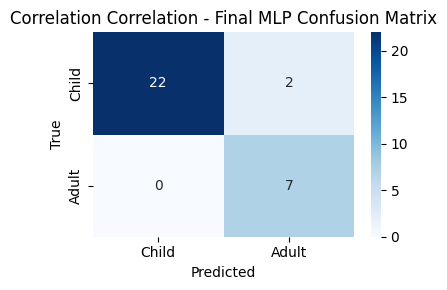


📊 Final MLP Classification Report (Partial Correlation)
              precision    recall  f1-score   support

       Child       0.96      1.00      0.98        24
       Adult       1.00      0.86      0.92         7

    accuracy                           0.97        31
   macro avg       0.98      0.93      0.95        31
weighted avg       0.97      0.97      0.97        31



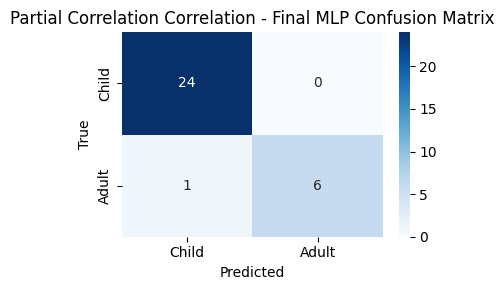


📊 Final MLP Classification Report (Tangent)
              precision    recall  f1-score   support

       Child       0.96      1.00      0.98        24
       Adult       1.00      0.86      0.92         7

    accuracy                           0.97        31
   macro avg       0.98      0.93      0.95        31
weighted avg       0.97      0.97      0.97        31



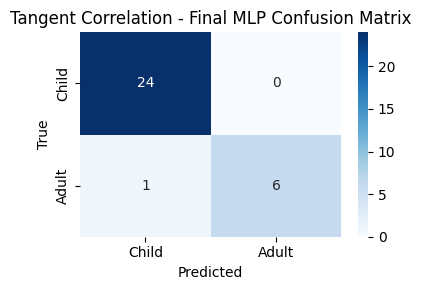

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

for kind in correlation_types: #loop through correlation types
    print(f"\n📊 Final MLP Classification Report ({kind.title()})")
    #pulls the saved test data for the kind of correlation matrix in question
    X_test = split_data[kind]["X_test"]
    y_test = split_data[kind]["y_test"]

    # Use the StandardScaler and trained MLPClassifier for each correlation(done during training)
    scaler = scalers[kind]
    model = best_models[kind]
    
    #apply the same scaling as the training set
    X_test_scaled = scaler.transform(X_test)
    #predict labels for the test set
    y_pred = model.predict(X_test_scaled)
    
    print(classification_report(y_test, y_pred, target_names=["Child", "Adult"]))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred) #2x2 matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Child", "Adult"], yticklabels=["Child", "Adult"])
    plt.title(f"{kind.title()} Correlation - Final MLP Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


📊 Insights: Final MLP Classification Performance
- After performing hyperparameter tuning with GridSearchCV, the optimized MLP models were evaluated on the test set using three types of correlation matrices: Correlation, Partial Correlation, and Tangent. The key observations are:

✅ Overall Accuracy:
- Partial Correlation and Tangent achieved the highest accuracy: 97%
- Pearson Correlation followed closely behind with 94%

📈 Class-Level Performance:
Child class (majority class) was classified with nearly perfect precision and recall across all correlation types.

- Adult class (minority class) showed the most variation:
- Best recall (1.00) was achieved using Pearson Correlation
- Best precision (1.00) was achieved using Partial Correlation and Tangent

**Interpretation:**
- Partial Correlation and Tangent matrices not only maintained high overall accuracy but also - struck a better balance between precision and recall for the minority Adult class.
- This suggests they might capture more subtle age-related connectivity patterns compared to raw Pearson correlation.

📌 Recommendation:
- While all three methods are strong, Partial Correlation and Tangent Correlation are most robust for both classifying Children and Adults effectively.
- They are especially valuable in contexts where minimizing false negatives for Adults is crucial.



## 6. Plot MLP Accuracies

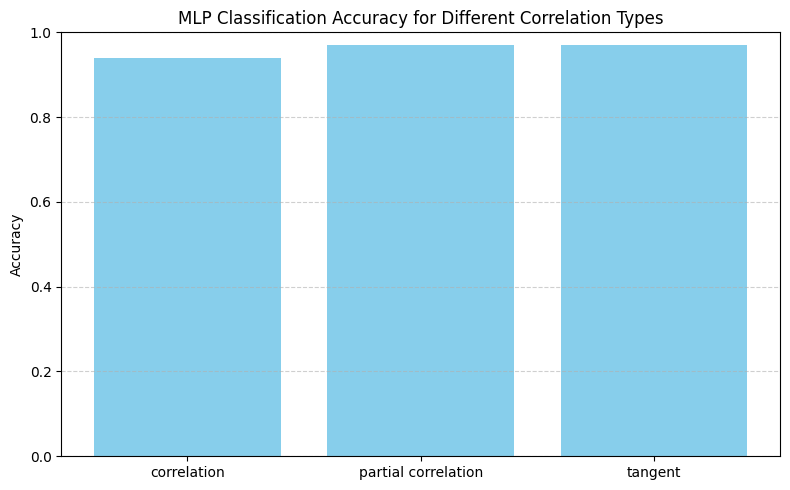

In [29]:
import matplotlib.pyplot as plt

# Accuracy values for MLP from screenshots (based on confusion matrix summaries)
mlp_accuracies = {
    "correlation": 0.94,
    "partial correlation": 0.97,
    "tangent": 0.97
}

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(mlp_accuracies.keys(), mlp_accuracies.values(), color='skyblue')
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("MLP Classification Accuracy for Different Correlation Types")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# 7. Compare with GCN Accuracies

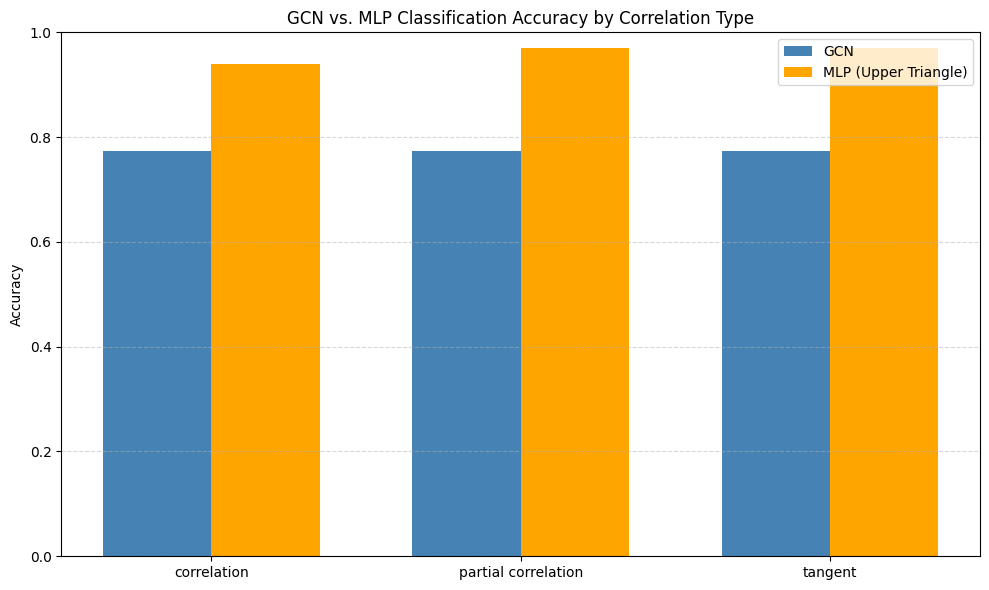

In [ ]:
import numpy as np

# Assuming representative best values for each correlation type (averaged or selected from the plot)
gcn_accuracies = {
    "correlation": 0.7742,
    "partial correlation": 0.7742,
    "tangent": 0.7742
}

# Plotting side-by-side comparison
labels = list(mlp_accuracies.keys())
x = np.arange(len(labels))  # Label positions

bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - bar_width/2, [gcn_accuracies[k] for k in labels], width=bar_width, label='GCN', color='steelblue')
plt.bar(x + bar_width/2, [mlp_accuracies[k] for k in labels], width=bar_width, label='MLP (Upper Triangle)', color='orange')

plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("GCN vs. MLP Classification Accuracy by Correlation Type")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


MLP:
- Treats each subject as a flat row of numbers — like a spreadsheet.
- It doesn’t care which brain regions are connected to each other.
- It just learns from the overall pattern of correlations.

GCN:
Thinks of each subject as a graph:
- Nodes = brain regions
- Edges = connections (from your correlation matrix)
- Each node can "talk" to its neighbors and update its information based on them.
- This lets GCN capture relationships between regions — not just their individual values.